# Constructed-Token Experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [1]:
import os
import jax
import jax.numpy as jnp
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from flax.training import train_state
from typing import Dict, List, Tuple

from configs.config import get_experiment_config, get_model_config
from src.training_init import TrainingInitializer
import src.models.auxiliary_models as aux
from src.util.probings.probe_layers import ProbeLayers
from src.models.auxiliary_models import GDSequenceSolver, LeastSquaresSequenceSolver
from src.util.sequence_performance.sequenceloss_eval import SequencePredictionEvaluator
from src.util.interpolation.interpolator import Interpolator

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

path_model_1 = 'experiment_results/linear_seq_fully/model_lin_1l_constr.pkl'
path_model_2 = 'experiment_results/linear_seq_fully/model_lin_2l_constr.pkl'
path_model_4 = 'experiment_results/linear_seq_fully/model_lin_4l_constr.pkl'
path_model_6 = 'experiment_results/linear_seq_fully/model_lin_6l_constr.pkl'
path_model_mesa = 'experiment_results/linear_seq_fully/model_mesa_constr.pkl'

path_seqperf_single = 'experiment_results/linear_seq_fully/seqperf_results_constr_single.pkl'
path_seqperf_multi = 'experiment_results/linear_seq_fully/seqperf_results_constr_multi.pkl'
path_probing_results = 'experiment_results/linear_seq_fully/probing_results_constr.pkl'
path_interpol_results_single = 'experiment_results/linear_seq_fully/interpol_results_single.pkl'
path_interpol_results_multi = 'experiment_results/linear_seq_fully/interpol_results_multi.pkl'
path_mesa_loss_results = 'experiment_results/linear_seq_fully/mesa_test_loss.pkl'

print(f'Running on Devices: {gpus},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


**Define Models:**

<font color='grey'>Arguments for Model-Config, Seperated by '.':</font> <br>
    - model: Defines Model Type (fixed settings for all other fields). See config.py file for further information.<br>
    - layers: No. of layers in the Transformer. For certain model types (such as those used here), we have layers = 'True' model-layers - 1, as we add another special layer which incorporates the PE-logic in the attention. Thus, a six-layer model is actually seven layers deep. A layer comprises of the multi-head attention mechanism as well as potentially various types of (Layer-) Normalization mechanisms, MLPs and standard residual connections.<br>
    - heads: No. of attention heads.<br>
    - embed_dim: Dimension of embeddings used for computations in the Transformer. <br>
    - seq_len: Length of input sequence lengths.<br>
    - key_size: Key-size per head in attention. <br>
    - pe_kq: Use Positional encodings in keys/queries in special first layer instead of adding them to the residual stream.<br>
    - pe_emb: Use standard Positional encodings, added to the residual stream before the first Transformer layer. <br>
    - laynorm: Use standard Layer-Normalization in each Transformer layer.<br>
    - mlp: Use standard MLP in Transformer layers. Activation function is GeLu (jax.nn.gelu).<br>
    - dim_mlp: Dimension of hidden MLP layers.<br>
    - linear: Use linear self-attention.<br>
    - clip: Use forward-pass activation clipping (of the residual stream).<br>
    - clip_val: Clipping bandwidth (i.e. x <- Clip(x, min=-clip_val, max=clip_val)). <br>
    - schlagnorm: Use 'Schlag-Normalization' as proposed by Schlag, 2021: Separate Normalization of query and key projections in the attention-mechanism.<br>
    - schlagnorm_t: Also normalize value projections.<br>
    - schlagnorm_hyb: Use Schlag-Norm in the first layer.<br>
    - schlagnorm_t_hyb: Also normalize value projections in the first layer.<br>

In [3]:
models_constr_lay = lambda lay: f'fully_obs_constructed_transformer.{lay}.{2 if lay == 1 else 4}.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False'
model_mesa_desc = 'fully_obs_constructed_mesa.1.4.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False'

## Training models:

### Single-layer Transformer:

In [4]:
exp_config_constr_1 = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
(model_tf_1, optimizer_1, data_generator_1, train_module_1) = TrainingInitializer(model_config=get_model_config(models_constr_lay(1)), 
                                                                                  experiment_config=exp_config_constr_1).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_1, rng = train_module_1.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_1, train_rng, _, _, _ = train_module_1.train_epoch(epoch=epoch_idx,
                                                                    state=state_tf_1,
                                                                    rng=train_rng,
                                                                    test_rng=test_rng,
                                                                    num_batches_train=100,
                                                                    interpolate=False)
                        
    if store_results:
        print(f'Storing parameters in path=\'{path_model_1}\'')
        a = {'params' : state_tf_1.params}
        with open(path_model_1, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_1, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_1 = train_state.TrainState.create(apply_fn=model_tf_1.apply, params=a['params'], tx=optimizer_1)

model:  fully_obs_constructed_transformer  layers: 1  heads:  2  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [5]:
exp_config_constr_m = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
exp_config_constr_m.optim.peak_lr = 4e-4
(model_m, optimizer_m, data_generator_m, train_module_m) = TrainingInitializer(model_config=get_model_config(model_mesa_desc), 
                                                                               experiment_config=exp_config_constr_m).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa, rng = train_module_m.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
                        state_mesa, train_rng, _, _, _ = train_module_m.train_epoch(epoch=epoch_idx,
                                                                                    state=state_mesa,
                                                                                    rng=train_rng,
                                                                                    test_rng=test_rng,
                                                                                    num_batches_train=100,
                                                                                    interpolate=False)
    if store_results:
        print(f'Storing parameters in path=\'{path_model_mesa}\'')
        a = {'params' : state_mesa.params}
        with open(path_model_mesa, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_mesa, 'rb') as handle:
        a = pkl.load(handle)
    state_mesa = train_state.TrainState.create(apply_fn=model_m.apply, params=a['params'], tx=optimizer_m)

model:  fully_obs_constructed_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


### Multi-layer Transformer:

In [6]:
exp_config_constr_2 = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
(model_tf_2, optimizer_2, data_generator_2, train_module_2) = TrainingInitializer(model_config=get_model_config(models_constr_lay(2)), 
                                                                                  experiment_config=exp_config_constr_2).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_2, rng = train_module_2.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_2, train_rng, _, _, _ = train_module_2.train_epoch(epoch=epoch_idx,
                                                                    state=state_tf_2,
                                                                    rng=train_rng,
                                                                    test_rng=test_rng,
                                                                    num_batches_train=100,
                                                                    interpolate=False)
                        
    if store_results:
        print(f'Storing parameters in path=\'{path_model_2}\'')
        a = {'params' : state_tf_2.params}
        with open(path_model_2, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_2, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_2 = train_state.TrainState.create(apply_fn=model_tf_2.apply, params=a['params'], tx=optimizer_2)

model:  fully_obs_constructed_transformer  layers: 2  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [7]:
exp_config_constr_4 = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
(model_tf_4, optimizer_4, data_generator_4, train_module_4) = TrainingInitializer(model_config=get_model_config(models_constr_lay(4)), 
                                                                                  experiment_config=exp_config_constr_4).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_4, rng = train_module_4.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_4, train_rng, _, _, _ = train_module_4.train_epoch(epoch=epoch_idx,
                                                                    state=state_tf_4,
                                                                    rng=train_rng,
                                                                    test_rng=test_rng,
                                                                    num_batches_train=100,
                                                                    interpolate=False)
                        
    if store_results:
        print(f'Storing parameters in path=\'{path_model_4}\'')
        a = {'params' : state_tf_4.params}
        with open(path_model_4, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_4, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_4 = train_state.TrainState.create(apply_fn=model_tf_4.apply, params=a['params'], tx=optimizer_4)

model:  fully_obs_constructed_transformer  layers: 4  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [8]:
exp_config_constr_6 = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
(model_tf_6, optimizer_6, data_generator_6, train_module_6) = TrainingInitializer(model_config=get_model_config(models_constr_lay(6)), 
                                                                                  experiment_config=exp_config_constr_6).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_6, rng = train_module_6.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(150):
        state_tf_6, train_rng, _, _, _ = train_module_6.train_epoch(epoch=epoch_idx,
                                                                    state=state_tf_6,
                                                                    rng=train_rng,
                                                                    test_rng=test_rng,
                                                                    num_batches_train=100,
                                                                    interpolate=False)
                        
    if store_results:
        print(f'Storing parameters in path=\'{path_model_6}\'')
        a = {'params' : state_tf_6.params}
        with open(path_model_6, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_6, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_6 = train_state.TrainState.create(apply_fn=model_tf_6.apply, params=a['params'], tx=optimizer_6)

model:  fully_obs_constructed_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


## Sequence performance analyses:

### Single-layer:

In [9]:
gd_solver = GDSequenceSolver(eta=0.032,
                             lamb=0.0)
model_names = ['transformer', 'gd']

In [10]:
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator_single = SequencePredictionEvaluator(data_generator=data_generator_1,
                                                   test_batch_size=256,
                                                   seeds=exp_config_constr_1.seeds,
                                                   model_list = model_names,
                                                   models = [model_tf_1, gd_solver],
                                                   states = [state_tf_1, None],
                                                   loss_fn = loss_fn)

if rerun_analyses:
    seq_loss_dict_single = seq_evaluator_single.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_single}\'')
        with open(path_seqperf_single, 'wb') as handle:
            pkl.dump(seq_loss_dict_single, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_single, 'rb') as handle:
        seq_loss_dict_single = pkl.load(handle)

### Multi-layer:

In [11]:
lsq_solver = LeastSquaresSequenceSolver(approximator='chebyshev',
                                        seq_len=50,
                                        apx_steps=20,
                                        lamb=0.001,
                                        alphas=[1.0257748, 3.2508426, 3.2583678, 3.2122886, 2.694414, 1.2727231],
                                        betas=[0.0, 0.6787798 , 0.30748147, 0.74470717, 1.8360422, 2.3438027 ])

In [12]:
model_names = ['transformer','transformer','transformer','transformer','mesa-transformer','lsq']
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator_multi = SequencePredictionEvaluator(data_generator=data_generator_6,
                                                  test_batch_size=256,
                                                  seeds=exp_config_constr_6.seeds,
                                                  model_list = model_names,
                                                  models = [model_tf_1, model_tf_2, model_tf_4, model_tf_6, model_m, lsq_solver],
                                                  states = [state_tf_1, state_tf_2, state_tf_4, state_tf_6, state_mesa, None],
                                                  loss_fn = loss_fn)

if rerun_analyses:
    seq_loss_dict_multi = seq_evaluator_multi.run()
    print(f'Storing performance evaluation dict. in path=\'{path_seqperf_multi}\'')
    with open(path_seqperf_multi, 'wb') as handle:
        pkl.dump(seq_loss_dict_multi, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_multi, 'rb') as handle:
        seq_loss_dict_multi = pkl.load(handle)

## Probing analyses:

In [13]:
if rerun_analyses:
    probing_dict = ProbeLayers(experiment_config=exp_config_constr_6,
                               data_generator=data_generator_6,
                               model_tf=model_tf_6,
                               state_tf=state_tf_6,
                               probes_list=['curr_probe', 'next_probe', 'inverse_curr_probe'],
                               inv_fn=aux.batched_chebyshev(steps=6,
                                                            alphas=[1.0257748, 3.2508426, 3.2583678, 3.2122886, 2.694414, 1.2727231],
                                                            betas=[0.0, 0.6787798 , 0.30748147, 0.74470717, 1.8360422, 2.3438027 ])).run()
    if store_results:
        print(f'Storing probing results in path=\'{path_probing_results}\'')
        with open(path_probing_results, 'wb') as handle:
            pkl.dump(probing_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_probing_results, 'rb') as handle:
        probing_dict = pkl.load(handle)

## Interpolation:

In [14]:
exp_config_interpol_single = get_experiment_config(experiment='interpol_one', seeds=[1, 11, 111, 1111, 11111])
exp_config_interpol_multi = get_experiment_config(experiment='interpol_six', seeds=[1, 11, 111, 1111, 11111])
models_constr_interpol = lambda lay: f'fully_obs_constructed_transformer.{lay}.{2 if lay == 1 else 4}.40.50.{20 if lay == 1 else 40}.False.False.False.False.0.True.True.4.False.False.False.False'

if rerun_analyses:
    interpol_result_dict_single = Interpolator(model_config=get_model_config(models_constr_interpol(1)), 
                                               experiment_config=exp_config_interpol_single).run() 
    interpol_result_dict_multi = Interpolator(model_config=get_model_config(models_constr_interpol(6)), 
                                              experiment_config=exp_config_interpol_multi).run() 
    if store_results:
        print(f'Storing one-layer interpolation results in path=\'{path_interpol_results_single}\'')
        print(f'Storing six-layer interpolation results in path=\'{path_interpol_results_multi}\'')
        with open(path_interpol_results_single, 'wb') as handle:
            pkl.dump(interpol_result_dict_single, handle, protocol=pkl.HIGHEST_PROTOCOL)
        with open(path_interpol_results_multi, 'wb') as handle:
            pkl.dump(interpol_result_dict_multi, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_interpol_results_single, 'rb') as handle:
        interpol_result_dict_single = pkl.load(handle)
    with open(path_interpol_results_multi, 'rb') as handle:
        interpol_result_dict_multi = pkl.load(handle)

In order to compare the interpolations to the mesa-layer, we train it for the same seeds and report the mean test loss during training:

In [15]:
if rerun_models: 
    exp_config_mesa_interpol = get_experiment_config(experiment='probing_constr', seeds=[1, 11, 111, 1111, 11111])
    exp_config_mesa_interpol.optim.peak_lr = 4e-4
    for s_idx, seed in enumerate(exp_config_mesa_interpol.seeds):
        (model_mesa_s, optimizer_mesa_s, data_generator_mesa_s, train_module_mesa_s) = TrainingInitializer(model_config=get_model_config(model_mesa_desc), 
                                                                                    experiment_config=exp_config_mesa_interpol).run()
        rng = jax.random.PRNGKey(seed)
        rng, test_rng, train_rng = jax.random.split(rng, 3)
        state_mesa_s, rng = train_module_mesa_s.get_init_state(rng, interpol_call=False)
        for epoch_idx in range(150):
            state_mesa_s, train_rng, test_loss, _, _ = train_module_mesa_s.train_epoch(epoch=epoch_idx,
                                                                                        state=state_mesa_s,
                                                                                        rng=train_rng,
                                                                                        test_rng=test_rng,
                                                                                        num_batches_train=100,
                                                                                        interpolate=False)
            mesa_losses = mesa_losses.at[s_idx, epoch_idx].set(test_loss)
    mean_loss_mesa = list(jnp.mean(mesa_losses,axis=0))
    std_loss_mesa = list(jnp.std(mesa_losses, axis=0))
    if store_results:
        print(f'Storing mesa-layer test loss results in path=\'{path_mesa_loss_results}\'')
        with open(path_mesa_loss_results, 'wb') as handle:
            pkl.dump({'mean_loss_mesa' : mean_loss_mesa,
                      'std_loss_mesa' : std_loss_mesa}, 
                      handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_mesa_loss_results, 'rb') as handle:
        a = pkl.load(handle)
    mean_loss_mesa = a['mean_loss_mesa']
    std_loss_mesa = a['std_loss_mesa']

## Visualization of results:

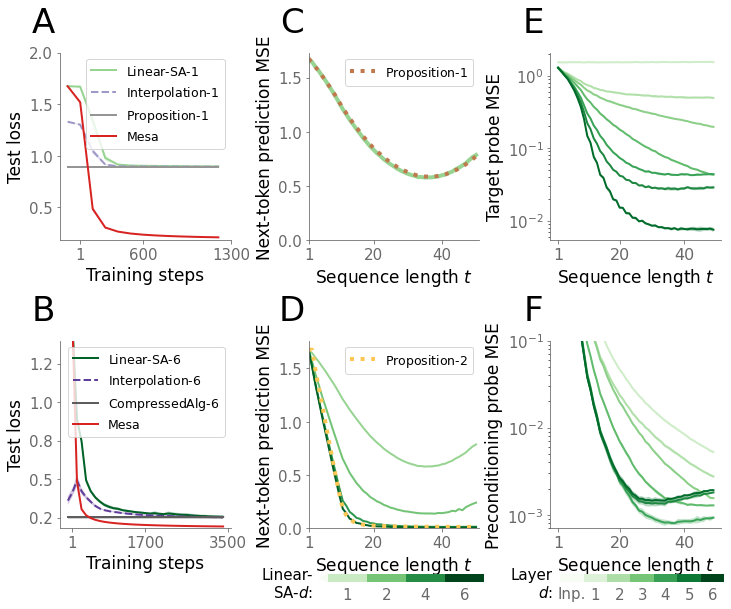

In [16]:
legend_fontsize = 'small'

def subplot_probe(ax,
                  cols: List,
                  mean: List,
                  std: List,
                  name: str,
                  num_graphs: int):
    for i in range(num_graphs):
        c = cols[i]
        linestyle = 'solid'
        ax.plot(jnp.array(mean)[:,i], linewidth=2, color=c, linestyle=linestyle, label=f'$d={i}$')
        ax.fill_between(range(mean.shape[0]), (mean[:,i]-std[:,i]),(mean[:,i]+std[:,i]) ,alpha=0.3, facecolor=c)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel(name)
    ax.set_yscale('log')
    ax.set_xticks([0,19,39],[1,20,40],fontsize=16)

def subplot_interpol(ax,
                     c_tf,
                     c_ip,
                     c_revalg,
                     c_mesa,
                     interpol_dict: Dict[str, any],
                     plot_len: int,
                     is_linear: bool,
                     num_layers: int,
                     ylim: Tuple[int],
                     mesa_mean: List,
                     mesa_std: List):
    name = 'Linear' if is_linear else 'Softmax'
    tf_losses = interpol_dict['tf_losses_multiseed']
    ip_losses = interpol_dict['interpolation_losses_multiseed']
    revalg_losses = interpol_dict['revAlg_losses']
    tf_mean, tf_std = jnp.mean(jnp.array(tf_losses),axis=0)[:plot_len], jnp.std(jnp.array(tf_losses),axis=0)[:plot_len]
    ip_mean, ip_std = jnp.mean(jnp.array(ip_losses),axis=0)[:plot_len], jnp.std(jnp.array(ip_losses),axis=0)[:plot_len]
    rev_mean, rev_std = jnp.mean(jnp.array(revalg_losses),axis=0), jnp.std(jnp.array(revalg_losses),axis=0)

    ax.fill_between(range(plot_len),(tf_mean-tf_std),(tf_mean+tf_std),alpha=0.3,facecolor=c_tf)
    ax.plot(tf_mean, label=f'{name}-SA-${num_layers}$', linewidth=2, color=c_tf, alpha=1)

    ax.fill_between(range(plot_len), ip_mean-ip_std, ip_mean+ip_std ,alpha=0.3, facecolor=c_ip)
    ax.plot(ip_mean, label=f'Interpolation-${num_layers}$', linewidth=2, linestyle='dashed', color=c_ip, alpha=1)

    ax.fill_between(range(plot_len), [rev_mean-rev_std for _ in range(plot_len)], [rev_mean+rev_std for _ in range(plot_len)] ,alpha=0.3, facecolor=c_revalg)
    ax.plot([rev_mean for _ in range(plot_len)], linewidth=2, label=f'CompressedAlg-${num_layers}$' if num_layers > 1 else 'Proposition-$1$', color=c_revalg, alpha=1)

    ax.fill_between(range(plot_len),(list(jnp.array(mesa_mean)-jnp.array(mesa_std))[:plot_len]),(list(jnp.array(mesa_mean)+jnp.array(mesa_std))[:plot_len]),alpha=0.3,facecolor=c_mesa)
    ax.plot(mesa_mean[:plot_len], label=f'Mesa', linewidth=2, color=c_mesa, alpha=1)

    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_ylim(ylim)
    ax.set_xticks([1,plot_len//2, plot_len], [1,plot_len//2*100, plot_len*100])
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Test loss')
    ax.legend(loc=1, fontsize=legend_fontsize)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def subplot_perf(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List):
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = tuple([jnp.mean(loss_arr[idx],axis=0) for idx in range(len(model_list))])   # LSA vs GDexact vs Mesa vs LSQ
    std_losses = tuple([jnp.std(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    for idx in range(len(model_list)):
        ax.plot(mean_losses[idx], linewidth=2*(2 if (model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] or model_list[idx] == 'LSA-$1$') else 1), linestyle='dotted' if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 'solid', label=(model_list[idx] if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else None), color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])

    formatter = FuncFormatter(lambda x, _: '{:.1f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next-token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.legend(loc=1, fontsize=legend_fontsize)
    ax.set_xticks([0,19,39],[1,20,40])

def plot_fig3(result_dict_probe: Dict[str,any],
              interpol_dict_one: Dict[str, any],
              interpol_dict_six: Dict[str, any],
              mesa_test_loss_mean: List,
              mesa_test_loss_std: List,
              seq_loss_dict_one: Dict[str, any],
              seq_loss_dict_six: Dict[str, any],
              model_list_one: List[str],
              model_list_six: List[str]):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    # Extract Probe info:
    results_prob = result_dict_probe['results']
    _, next_probes, inv_curr_probes, _, _ = tuple([jnp.array(res) for res in results_prob])
    mean_next_probes = jnp.mean(next_probes, axis=0)[1:,:]
    std_next_probes = jnp.std(next_probes, axis=0)[1:,:]
    mean_inv_curr_probes = jnp.mean(inv_curr_probes, axis=0)[1:,:]
    std_inv_curr_probes = jnp.std(inv_curr_probes, axis=0)[1:,:]

    num_graphs = len(mean_next_probes[1])
    colormap_lin = plt.get_cmap('Greens', 100)
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    c_tf1, c_tf2, c_tf4, c_tf6 = tuple([plt.get_cmap('Greens', 100)(acc) for acc in [40,50,70,90]])
    c_revalg1 = plt.get_cmap('Greys', 100)(50)
    c_ip1 = plt.get_cmap('Purples', 100)(50)
    c_revalg6 = plt.get_cmap('Greys', 100)(70)
    c_ip6 = plt.get_cmap('Purples', 100)(80)
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    c_gd = plt.get_cmap('copper', 100)(60)
    c_mesa = plt.get_cmap('Reds', 100)(70)

    cols_p1 = [c_tf1, c_gd]
    cols_p6 = [c_tf1, c_tf2, c_tf4, c_tf6, c_lsq]

    fig, axs = plt.subplots(nrows=2,
                            ncols=3,
                            figsize=(10, 8),
                            gridspec_kw={'width_ratios': [1,1,1]},
                            layout='constrained')

    ################################################
    # Interpolations:
    subplot_interpol(ax=axs[0,0],
                     c_tf=c_tf1,
                     c_ip=c_ip1,
                     c_revalg=c_revalg1,
                     c_mesa=c_mesa,
                     interpol_dict=interpol_dict_one,
                     plot_len=13,
                     is_linear=True,
                     num_layers=1,
                     ylim=(0.18,2),
                     mesa_mean=mesa_test_loss_mean,
                     mesa_std=mesa_test_loss_std)
    subplot_interpol(ax=axs[1,0],
                     c_tf=c_tf6,
                     c_ip=c_ip6,
                     c_revalg=c_revalg6,
                     c_mesa=c_mesa,
                     interpol_dict=interpol_dict_six,
                     plot_len=35,
                     is_linear=True,
                     num_layers=6,
                     ylim=(0.18,1.4),
                     mesa_mean=mesa_test_loss_mean,
                     mesa_std=mesa_test_loss_std)

    ################################################
    # Performance - Analyses:
    subplot_perf(ax=axs[0,1],
                 seq_loss_dict=seq_loss_dict_one,
                 model_list=model_list_one,
                 cols=cols_p1)
    #axs[0,1].set_ylim(0.55,)
    subplot_perf(ax=axs[1,1],
                 seq_loss_dict=seq_loss_dict_six,
                 model_list=model_list_six,
                 cols=cols_p6)

    box = axs[1, 1].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0+0.04, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, cmap.N, extend='min')
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$1$", "$2$", "$4$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.03, label_y_position+0.005, 'Linear-\nSA-$d$:', va='center', ha='right', rotation='horizontal')

    ################################################
    # Probes:
    subplot_probe(ax=axs[0,2],
                  cols=subplot_col_fn(colormap_lin),
                  mean=mean_next_probes,
                  std=std_next_probes,
                  name='Target probe MSE',
                  num_graphs = num_graphs)
    subplot_probe(ax=axs[1,2],
                  cols=subplot_col_fn(colormap_lin),
                  mean=mean_inv_curr_probes,
                  std=std_inv_curr_probes,
                  name='Preconditioning probe MSE',
                  num_graphs = num_graphs)
    axs[1,2].set_ylim(0.0007,0.1)

    # Corresponding Colorbar:
    box = axs[1, 2].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0+0.1, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5,6,7,8]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["Inp.", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.09, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')
    ################################################

    labels = ['A', 'C', 'E', 'B', 'D', 'F']
    for ax, label in zip(axs.flat, labels):
        ax.text(-0.1, 1.07, label, transform=ax.transAxes, fontsize=34, ha='center', va='bottom')
    
    if store_results:
        fig.savefig('constr_plots.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

plot_fig3(result_dict_probe = probing_dict,
          interpol_dict_one = interpol_result_dict_single,
          interpol_dict_six = interpol_result_dict_multi,
          mesa_test_loss_mean = mean_loss_mesa,
          mesa_test_loss_std = std_loss_mesa,
          seq_loss_dict_one = seq_loss_dict_single,
          seq_loss_dict_six = seq_loss_dict_multi,
          model_list_one = ['LSA-$1$', 'Proposition-$1$'],
          model_list_six = ['LSA-$1$.', 'LSA-$2$', 'LSA-$4$', 'LSA-$6$', 'Proposition-$2$'])